In [ ]:
import os
import time
import cv2

In [ ]:
path_to_images = os.path.join('data','images')
images_taken = 4

In [ ]:
#cap = cv2.VideoCapture(0)
#for num in range(images_taken):
#    print('Snapping image {}'.format(num))
#    ret, frame = cap.read()
#    image_name = os.path.join(path_to_images, '.jpg')
#    cv2.imwrite(image_name, frame)
#    cv2.imshow('frame', frame)
#    time.sleep(0.5)

#    if cv2.waitKey(0) & 0xFF == ord('q'):
#        break

#cap.release()
#cv2.destroyAllWindows()

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
images = tf.data.Dataset.list_files('/content/images_data/images/*.jpg')

In [ ]:
images.as_numpy_iterator().next()

b'/content/images_data/images/2023-05-08-112709_4.jpg'

In [ ]:
def get_image(x):
  # returns a byte-encoded image
  byte_img = tf.io.read_file(x)

  # we decode the image and return it
  return tf.io.decode_jpeg(byte_img)

In [ ]:
images = images.map(get_image)

In [ ]:
#images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# returns "batch_size" number of images
image_getter = images.batch(5).as_numpy_iterator()

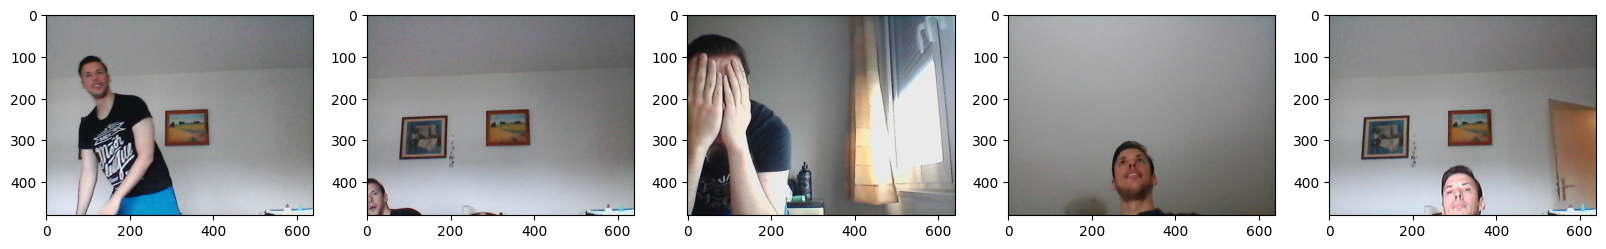

In [ ]:
show_images = image_getter.next()

fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(show_images):
  ax[idx].imshow(image)
plt.show()

In [ ]:
# Splitting the data to train, test, and validation partitions
# 60 to train, 16 to test, 16 to validation
# Done the splitting manually to ensure there is a proper variety of pictures in each partition

In [ ]:
for path in ['train', 'test', 'validation']:
  for file in os.listdir(os.path.join('/content/images_data', path, 'images')):
    file_name = file.split('.')[0] + '.json'
    label_filepath = os.path.join('/content/images_data', 'labeled_images', file_name)

    if os.path.exists(label_filepath):
      new_filepath = os.path.join('/content/images_data', path, 'labeled_images', file_name)
      os.replace(label_filepath, new_filepath)

In [ ]:
import albumentations as alb

In [ ]:
#image = cv2.imread(os.path.join('/content/images_data', 'images', '2023-05-08-111351_4.jpg'))

#image.shape

In [ ]:
image_augmentation = alb.Compose([alb.HorizontalFlip(p=0.5),
                                  alb.VerticalFlip(p=0.5),
                                  alb.RandomBrightnessContrast(p=0.2),
                                  alb.RGBShift(p=0.2),
                                  alb.RandomGamma(p=0.2),
                                  alb.RandomCrop(width=450, height=450)],
                                 bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [ ]:
rand_image = cv2.imread(os.path.join('/content/images_data', 'train', 'images', '2023-05-08-112546_4.jpg'))

In [ ]:
with open(os.path.join('/content/images_data', 'train', 'labeled_images', '2023-05-08-112546_4.json'), 'r') as f:
  image_label = json.load(f)

In [ ]:
image_label['shapes']

[{'label': 'Face :)',
  'points': [[324.1062801932367, 478.6473429951691],
   [218.79227053140102, 367.536231884058]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [ ]:
coordinates = [0,0,0,0]

coordinates[0] = image_label['shapes'][0]['points'][0][0]
coordinates[1] = image_label['shapes'][0]['points'][0][1]
coordinates[2] = image_label['shapes'][0]['points'][1][0]
coordinates[3] = image_label['shapes'][0]['points'][1][1]

coordinates

[324.1062801932367, 478.6473429951691, 218.79227053140102, 367.536231884058]

In [ ]:
coordinates = list(np.divide(coordinates, [640,480,640,480]))

coordinates

[0.5064160628019324,
 0.9971819645732689,
 0.3418629227053141,
 0.7657004830917875]

In [ ]:
tmp1 = coordinates[0]
tmp2 = coordinates[1]
coordinates[0] = coordinates[2]
coordinates[2] = tmp1

coordinates[1] = coordinates[3]
coordinates[3] = tmp2

In [ ]:
coordinates

[0.3418629227053141,
 0.7657004830917875,
 0.5064160628019324,
 0.9971819645732689]

In [ ]:
augmented_image = image_augmentation(image=rand_image, bboxes=[coordinates], class_labels=['Face :)'])

In [ ]:
augmented_image['bboxes']

[(0.38420826623725174,
  0.7500805152979066,
  0.6182393988191089,
  0.9969940955448202)]

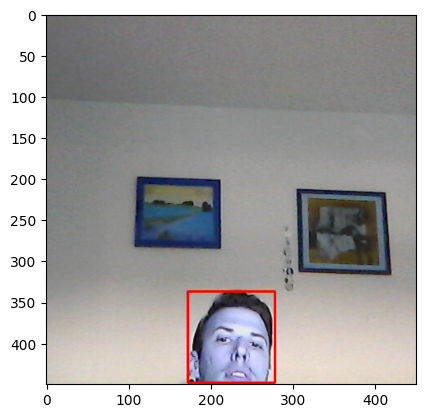

In [ ]:
cv2.rectangle(augmented_image['image'],
              tuple(np.multiply(augmented_image['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented_image['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented_image['image'])

In [ ]:
for partition in ['train', 'test', 'validation']:
  for image_path in os.listdir(os.path.join('/content/images_data', partition, 'images')):
    sample_image = cv2.imread(os.path.join('/content/images_data', partition, 'images', image_path))

    coordinates = [0, 0, 0.0001, 0.0001]
    label_path = os.path.join('/content/images_data', partition, 'labeled_images', f'{image_path.split(".")[0]}.json')
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = json.load(f)

        coordinates[0] = image_label['shapes'][0]['points'][0][0]
        coordinates[1] = image_label['shapes'][0]['points'][0][1]
        coordinates[2] = image_label['shapes'][0]['points'][1][0]
        coordinates[3] = image_label['shapes'][0]['points'][1][1]

        coordinates = list(np.divide(coordinates, [640,480,640,480]))
        x_min, y_min, x_max, y_max = coordinates[:4]
        if x_max <= x_min:
          coordinates[0], coordinates[2] = x_max, x_min
        if y_max <= y_min:
          coordinates[1], coordinates[3] = y_max, y_min

    try:
      for counter in range(60):
        augmented_image = image_augmentation(image=sample_image, bboxes=[coordinates], class_labels=['Face :)'])
        cv2.imwrite(os.path.join('/content/augmented_data', partition, 'images', f'{image_path.split(".")[0]}.{counter}.jpg'), augmented_image['image'])

        annotation = {}
        annotation['image'] = image_path

        if os.path.exists(label_path):
          if len(augmented_image['bboxes']) == 0:
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else:
            annotation['bbox'] = augmented_image['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0

        with open(os.path.join('/content/augmented_data', partition, 'labeled_images', f'{image_path.split(".")[0]}.{counter}.json'), 'w') as f:
          json.dump(annotation, f)

    except Exception as e:
      print(e)

In [ ]:
train_images = tf.data.Dataset.list_files('/content/augmented_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(get_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('/content/augmented_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(get_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('/content/augmented_data/validation/images/*.jpg', shuffle=False)
val_images = val_images.map(get_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
len(train_images)
#train.as_numpy_iterator().next()

3600

In [ ]:
def get_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('/content/augmented_data/train/labeled_images/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('/content/augmented_data/test/labeled_images/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('/content/augmented_data/validation/labeled_images/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
#len(train_labels)
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.549 , 0.    , 0.7827, 0.2411], dtype=float16))

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 960, 960, 960, 960)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1100)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1100)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3352  , 0.003006, 0.5693  , 0.2499  ],
        [0.3352  , 0.      , 0.5693  , 0.2144  ],
        [0.1351  , 0.81    , 0.3691  , 1.      ],
        [0.3599  , 0.      , 0.5938  , 0.2076  ],
        [0.1707  , 0.      , 0.4048  , 0.2188  ],
        [0.4663  , 0.7725  , 0.7     , 1.      ],
        [0.1707  , 0.817   , 0.4048  , 1.      ],
        [0.0729  , 0.779   , 0.307   , 1.      ]], dtype=float16))

In [ ]:
batch_sample = train.as_numpy_iterator()

In [ ]:
res = batch_sample.next()

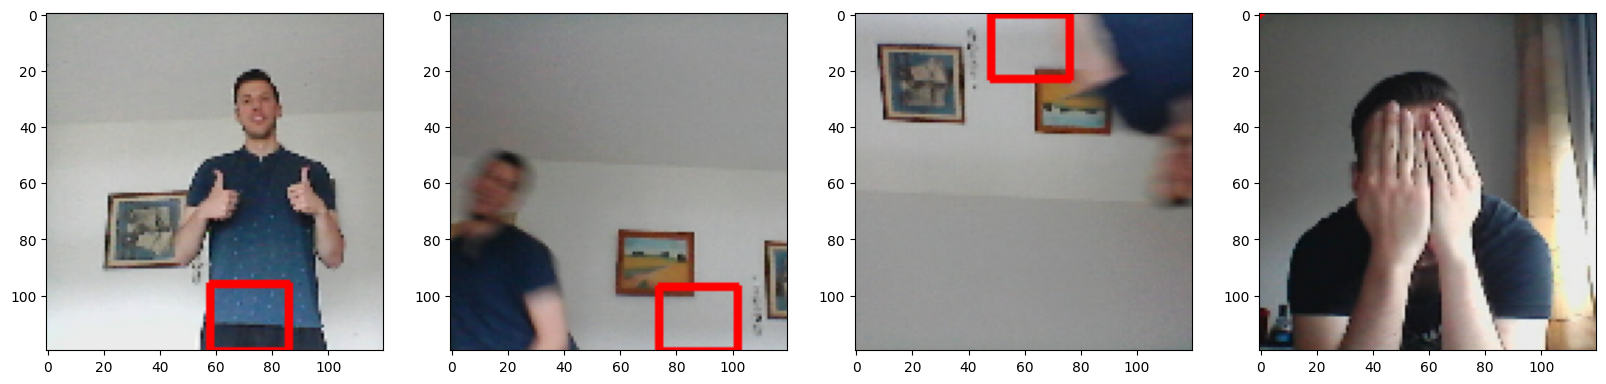

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [ ]:
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
#vgg.summary()

In [ ]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    return Model(inputs=input_layer, outputs=[class2, regress2])

In [ ]:
#train.as_numpy_iterator().next()[1]

In [ ]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 2s 2s/step


(array([[0.46327963],
        [0.5756866 ],
        [0.5409281 ],
        [0.4466392 ],
        [0.5378842 ],
        [0.46361843],
        [0.4102143 ],
        [0.44873708]], dtype=float32),
 array([[0.6027828 , 0.6552827 , 0.4774365 , 0.66115   ],
        [0.5475713 , 0.52909553, 0.57880574, 0.69109493],
        [0.57990766, 0.62811995, 0.4767488 , 0.63353765],
        [0.5473236 , 0.5702822 , 0.47777748, 0.6695928 ],
        [0.63295645, 0.6412287 , 0.53487855, 0.633598  ],
        [0.48803616, 0.5695951 , 0.48864752, 0.48260403],
        [0.559429  , 0.58656484, 0.5619788 , 0.5496041 ],
        [0.5822298 , 0.5316098 , 0.4828937 , 0.53609383]], dtype=float32))

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
print(localization_loss(y[1], coords))
print(classloss(y[0], classes))
print(regressloss(y[1], coords))

tf.Tensor(3.6147878, shape=(), dtype=float32)
tf.Tensor(0.76604724, shape=(), dtype=float32)
tf.Tensor(3.6147878, shape=(), dtype=float32)


In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [1]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

In [2]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')